In [ ]:
!pip install medmnist

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import PneumoniaMNIST
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from collections import Counter
import torch.optim as optim

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Dataset Loading and Exploration
Let us import the dataset and check how the data is looking like: to understand what preprocessing techniques can be used before deciding the model.

 Lets understand the dataset with meta data, using INFO dictionary



In [60]:
#dataset meta data
from medmnist import INFO

info = INFO['pneumoniamnist']
print("Task:", info['task'])
print("Class labels:", info['label'])
print("Number of channels:", info['n_channels'])
print("Number of samples:", info['n_samples'])

Task: binary-class
Class labels: {'0': 'normal', '1': 'pneumonia'}
Number of channels: 1
Number of samples: {'train': 4708, 'val': 524, 'test': 624}


what we can infer from this?
1. Since it is a binary class:  Binary classification
2. label info for normal and pneumonia patients
3. Based on number of channels we can say it is a grey scale image(channels= 1)
4. Dataset is already splitted to train,val and test, so we can directly load them


#Visualization

Lets see some sample images to understand

In [28]:
train_dataset = PneumoniaMNIST(split='train', download=True)
val_dataset = PneumoniaMNIST(split='val', download=True)
test_dataset = PneumoniaMNIST(split='test', download=True)

In [30]:
img, label = train_dataset[0]
print(img.size)

(28, 28)


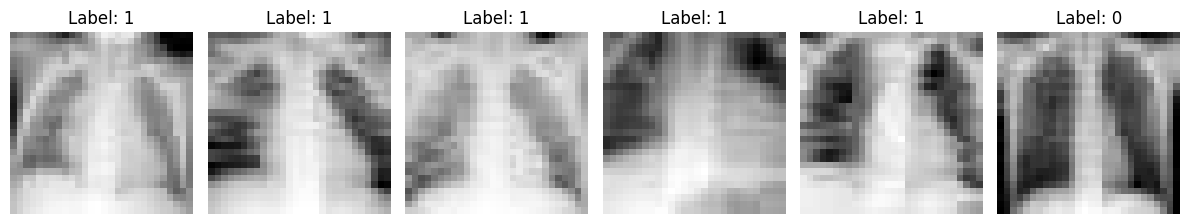

In [31]:
def show_samples(dataset, num_images=6):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        img, label = dataset[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label[0]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_samples(train_dataset)

Lets understand the distribution of classes in each split


In [32]:
def get_label_distribution(dataset):
    labels = [dataset[i][1][0] for i in range(len(dataset))]
    return Counter(labels)

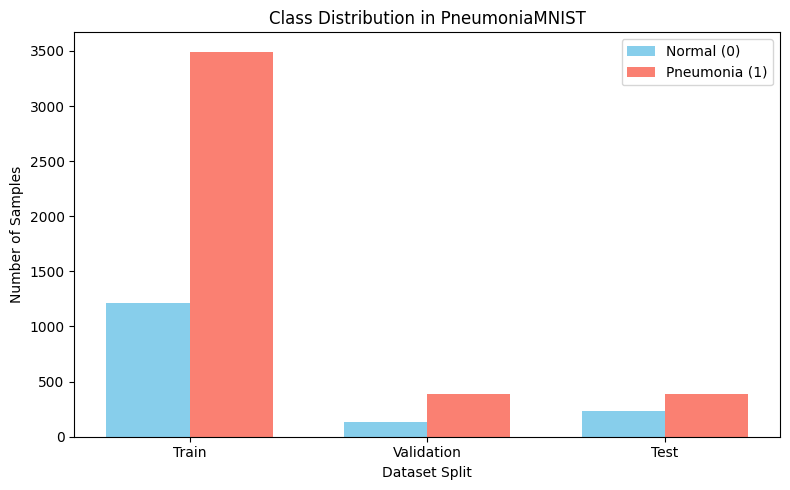

In [34]:
train_counts = get_label_distribution(train_dataset)
val_counts = get_label_distribution(val_dataset)
test_counts = get_label_distribution(test_dataset)
splits = ['Train', 'Validation', 'Test']
labels = ['Normal (0)', 'Pneumonia (1)']
normal_counts = [train_counts[0], val_counts[0], test_counts[0]]
pneumonia_counts = [train_counts[1], val_counts[1], test_counts[1]]

# Plot
x = range(len(splits))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, normal_counts, width, label='Normal (0)', color='skyblue')
plt.bar([p + width for p in x], pneumonia_counts, width, label='Pneumonia (1)', color='salmon')

# Axis labels and ticks
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in PneumoniaMNIST')
plt.xticks([p + width/2 for p in x], splits)
plt.legend()
plt.tight_layout()
plt.show()

based on the above plot we can say that it is a imbalanced dataset,training split has a significant class imbalance. Val and test have less skewed distribution but still more pneumonia cases than normal

#Problem:
1. The model may learn to over-predict pneumonia

Optimization / methods to overcome this:
1. we need to do class balancing : data augumentation, weighted loss functions, stratified splits
2. considering differnet evaluation metrics to evaluate the performance


#Pytorch Dataloaders

To use pytorch dataloaders, we need to convert all the numpy to tensors
using 'transform' in pytorch we can add all the preprocessing we need to carryout

In [61]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)


In [62]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#Model architecture
we added Convolutional layers to detect local patterns like edges and contours,Relu non-linearity so the model can learn complex patterns, Pooling layers to reduce spatial dimensions, and now we project to higher dimension and learn high level features. Fully connected layers combine all features and output a single score

In [79]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # output: 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2),                            # output: 32 x 14 x 14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# output: 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2),                            # output: 64 x 7 x 7
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),  # Binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x
model = SimpleCNN().to(device)
print("Model initialized and moved to device.")

Crossentropy loss :  For binary classification the last layer of the model should output two numbers if the model’s hidden size is d_model the last layer should be a linear layer with shape (d_model, 2). This gives us two logits, one for each class. The reason is that cross-entropy loss needs a probability for each class, so we take those logits, run them through a softmax

In [75]:
# 4. Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 20
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        #print(labels.shape)
        labels = labels.squeeze() # Squeeze the labels tensor
        optimizer.zero_grad()
        outputs = model(images)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze() # Squeeze the labels tensor
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Starting training...
Epoch 1/20, Train Loss: 0.3626, Val Loss: 0.2004, Val Accuracy: 91.98%
Epoch 2/20, Train Loss: 0.1671, Val Loss: 0.1241, Val Accuracy: 95.23%
Epoch 3/20, Train Loss: 0.1491, Val Loss: 0.1123, Val Accuracy: 94.85%
Epoch 4/20, Train Loss: 0.1306, Val Loss: 0.1007, Val Accuracy: 95.61%
Epoch 5/20, Train Loss: 0.1266, Val Loss: 0.0975, Val Accuracy: 95.61%
Epoch 6/20, Train Loss: 0.1259, Val Loss: 0.0974, Val Accuracy: 95.61%
Epoch 7/20, Train Loss: 0.1113, Val Loss: 0.1082, Val Accuracy: 95.42%
Epoch 8/20, Train Loss: 0.1079, Val Loss: 0.0909, Val Accuracy: 96.18%
Epoch 9/20, Train Loss: 0.0917, Val Loss: 0.1065, Val Accuracy: 95.42%
Epoch 10/20, Train Loss: 0.0929, Val Loss: 0.0894, Val Accuracy: 95.99%
Epoch 11/20, Train Loss: 0.0932, Val Loss: 0.0900, Val Accuracy: 96.18%
Epoch 12/20, Train Loss: 0.0848, Val Loss: 0.0854, Val Accuracy: 96.76%
Epoch 13/20, Train Loss: 0.0781, Val Loss: 0.0890, Val Accuracy: 95.99%
Epoch 14/20, Train Loss: 0.0743, Val Loss: 0.0812, V

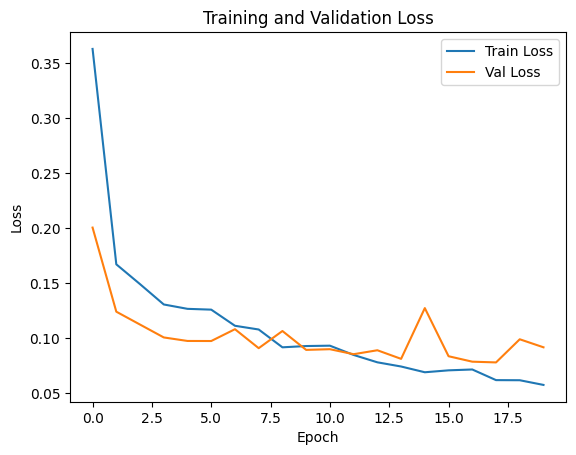

Plotting confusion matrix...


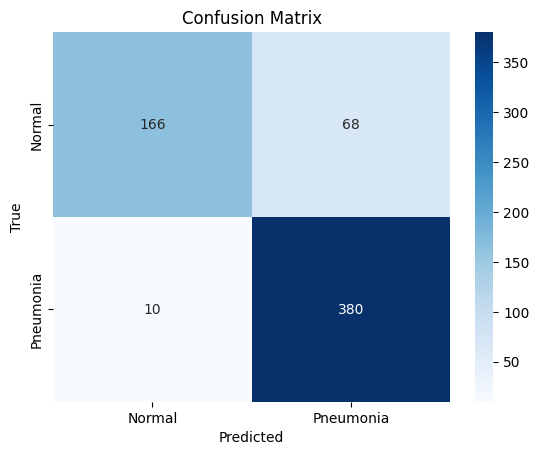

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.71      0.81       234
   Pneumonia       0.85      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.88      0.88      0.87       624

Plotting ROC curve...


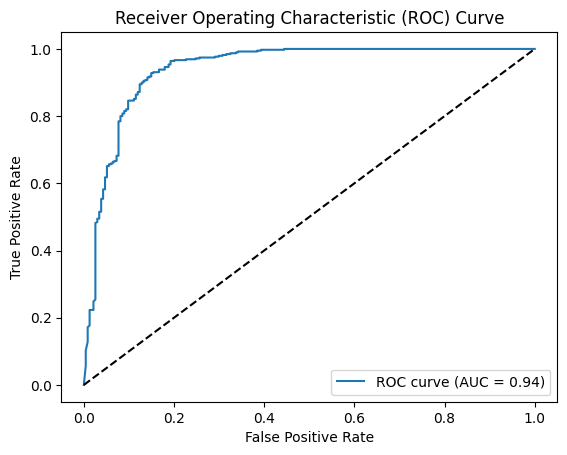

In [76]:

# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 5. Evaluation
model.eval()
all_preds = []
all_labels = []
total = 0
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Confusion Matrix
print("Plotting confusion matrix...")
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))

# 6. Additional Analyses
# ROC Curve
print("Plotting ROC curve...")
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




what confusion matrix tells us.

TP: 380 correctly predicted as Pneumonia when the true label is Pneumonia
TN: 166 correctly predicted as Normal when the true label is Normal
FN: 10 incorrectly predicted as Normal when the true label is Pneumonia
FP: 68 incorrectly predicted as Pneumonia when the true label is Normal

In this pneumonia detection task, False Negatives (FN) are the most important becasue it is risky missing a disease, and True Positives (TP) so that treatment is given at the right time

FP tells us that the more is biased towards Pneumonia class since there is class imbalance

What classification report tells us:

f1 score gives over all performance. with Pneumonia slightly outperforming Normal.

The high recall for Pneumonia is crucial in medical contexts, showing the model rarely misses a true case, while the lower recall for Normal indicates some Normal cases are misclassified as Pneumonia.

The higher precision for Normal suggests fewer false positives for this class, while the lower precision for Pneumonia indicates some false positives

what ROC curve tells us:
AUC = 0.94 the model performance is good,(AUC = 0.5) represents a random classifier

The model is highly effective, but we need to minimizing false positives.



#  BCEwithLogitsLoss
this loss is good for binary classification, so lets train our model with this loss. Change the last layer of the model to 1 output


In [82]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
val_losses = []

print("Starting training...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device).float().unsqueeze(1)
        y = y.squeeze(2) # Remove the extra dimension

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)
            y = y.squeeze(2) # Remove the extra dimension
            outputs = model(x)
            loss = criterion(outputs, y)
            val_running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += y.size(0)
            correct += (predicted == y).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Starting training...
Epoch 1/10, Train Loss: 0.4118, Val Loss: 0.2375, Val Accuracy: 86.64%
Epoch 2/10, Train Loss: 0.1914, Val Loss: 0.1649, Val Accuracy: 95.04%
Epoch 3/10, Train Loss: 0.1521, Val Loss: 0.1190, Val Accuracy: 95.42%
Epoch 4/10, Train Loss: 0.1419, Val Loss: 0.1070, Val Accuracy: 95.42%
Epoch 5/10, Train Loss: 0.1418, Val Loss: 0.1215, Val Accuracy: 94.66%
Epoch 6/10, Train Loss: 0.1305, Val Loss: 0.1249, Val Accuracy: 95.04%
Epoch 7/10, Train Loss: 0.1177, Val Loss: 0.0917, Val Accuracy: 96.18%
Epoch 8/10, Train Loss: 0.1084, Val Loss: 0.1096, Val Accuracy: 95.99%
Epoch 9/10, Train Loss: 0.1119, Val Loss: 0.0884, Val Accuracy: 95.99%
Epoch 10/10, Train Loss: 0.1036, Val Loss: 0.0892, Val Accuracy: 95.99%


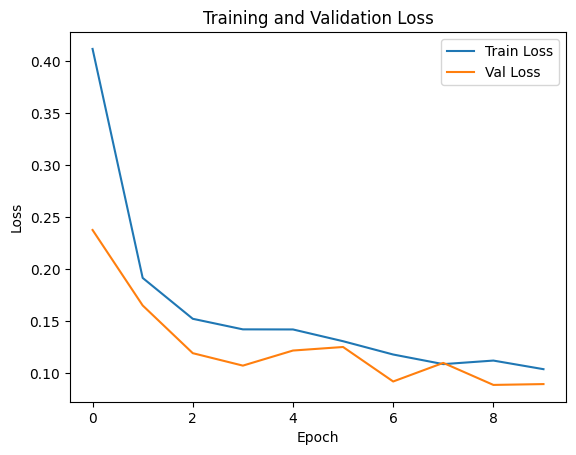

In [83]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()





Test Accuracy: 85.74%, Test Loss: 0.6605
Plotting confusion matrix...


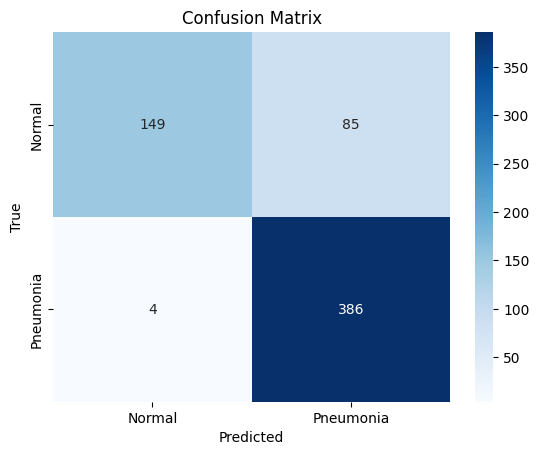

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.64      0.77       234
   Pneumonia       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624

Plotting ROC curve...


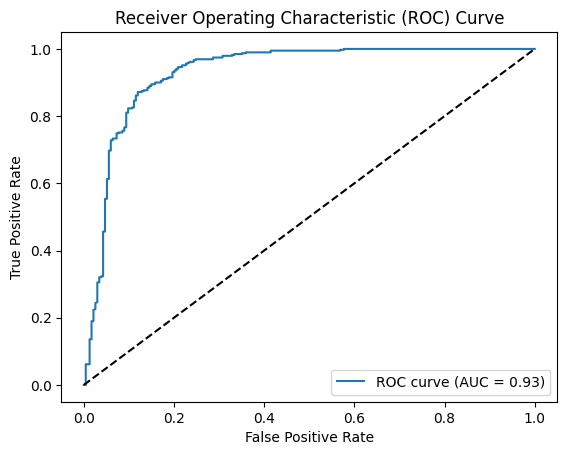

In [86]:
#evaluate
model.eval()
total = 0
correct = 0
total_loss = 0.0
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device).float().unsqueeze(1)
        y = y.squeeze(2) # Remove the extra dimension
        outputs = model(x)
        loss = criterion(outputs, y)
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += y.size(0)
        correct += (predicted == y).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)
print(f'Test Accuracy: {accuracy:.2f}%, Test Loss: {average_loss:.4f}')
# Confusion Matrix
print("Plotting confusion matrix...")
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))

# 6. Additional Analyses
# ROC Curve
print("Plotting ROC curve...")
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).squeeze() # Use sigmoid and squeeze to get probabilities
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Without any data agumentation and preprocessing our CNN model performed better, but lets try to improve these results
Cross entropy: 88% accuracy
BCEloss: 86% accuracy

lets include data agumentation and try if the model performance is improved
    